# Classifying customer complaints using Watson NLP

This notebook demonstrates how to train text classifiers using Watson NLP. The classifiers predict the product group from the text of a customer complaint. This could be used, for example to route a complaint to the appropriate staff member. 

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), a U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains the consumer’s narrative description of their experience if the consumer opted to share this information publicly and after the Bureau has removed all personal information. In this notebook, you will focus on complaints that contain this narrative description to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/. The dataset has been downloaded and saved in the [Box folder](https://ibm.box.com/shared/static/fbs5buv3iix9bbckaw5ojsjf4ntkwvcz.csv) for you.


## What you'll learn in this notebook

Watson NLP implements state-of-the-art classification algorithms from three different families: 
- Classic machine learning using SVM (Support Vector Machines)
- Deep learning using CNN (Convolutional Neural Networks)
- A transformer-based algorithm using the Google BERT multilingual model 

Watson NLP also offers an easy to use _ensemble classifier_ which combines different classification algorithms and a majority voting.

In this notebook, you'll learn how to:

- **Prepare your data** so that it can be used as training data for the Watson NLP classification algorithms.
- **Train a custom SVM model** using `watson_nlp.blocks.classification.SVM`. SVM stands for Support Vector Machines. It's an established classification method. We will run it based on USE (Universal Sentence Encoder) embeddings of the input text.
- **Train a VotingEnsemble** using `watson_nlp.workflows.classification.Ensemble`. The Ensemble model combines three classification models: CNN, SVM with TF-IDF and SVM with USE (Universal Sentence Encoder). It computes the weighted mean of classification predictions using confidence scores.
- **Store and load classification models** as an asset of a Watson Studio project.
- **Score data and compare model quality** by running the models on test data and using the built-in quality evaluation and building a custom confusion matrix.


## Table of Contents


1.	[Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.	[Data Processing](#prepareData)
    1. [Prepare training and test data](#prepareTraining)
1.  [Model Building](#buildModel)
    1. [Train a SVM classification model with Watson NLP](#svm)
    1. [Train an ensemble classification model with Watson NLP](#ensemble)
    1. [Store and load classification models](#storeLoad)
1.  [Model Evaluation](#evaluate)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _Default Python 3.8 + Watson NLP XS_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [2]:
%%capture
# word cloud is used to create graphs below
!pip install wordcloud
!pip install ibm-watson

In [3]:
import watson_nlp
# Silence Tensorflow warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

In [4]:
import json
import pandas as pd
from time import process_time
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import watson_nlp
from datetime import datetime

In [5]:
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.toolkit import fileio
from watson_nlp.blocks.classification.svm import SVM
from watson_nlp.workflows.classification import Ensemble
from watson_core.toolkit.quality_evaluation import QualityEvaluator, EvalTypes

<a id="loadData"></a>
## Data Loading (customer complaint data)

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. The data is exported in CSV format.

Read the data into a dataframe.
You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In your analysis you will focus on the *Product* column, which contains the product group, and the column with the complaint text *Consumer complaint narrative*.

<span style="color:blueviolet">We load the consumer complaints into a DataFrame.</span>

<span style="color:blue">This data set contains 999285 consumer complaints with the date received,product,sub-product, submitted via and company information.</span>

In [6]:
url = "https://ibm.box.com/shared/static/fbs5buv3iix9bbckaw5ojsjf4ntkwvcz.csv"
complaint_df = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

complaint_df.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,Complaint ID
0,14,2022-03-07,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,"I have been disputing fraud accounts on my credit report since XX/XX/XXXX. I keep sending multiple sets of letters to the bureaus so the excuse of "" we didn't get it '' doesn't happen. Furthermore, each letter is signed and attached with an FTC and Identity Theft affidavit, yet the bureaus are still not taking any actions. The accounts are not showing in dispute nor are they removed from my re...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,Experian Information Solutions Inc.,5291446
1,16,2022-03-21,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,Beginning in XXXX of XXXX I reached out to Midland Credit to request information pertaining to a debt showing on my credit report that I did not recognize. I requested information and validation of the debt and did not receive any information or correspondents. I sent multiple letters and did not receive any of the requested information. \n\nIn XXXX of XXXX I started receiving court paper and ...,NaN,ENCORE CAPITAL GROUP INC.,5348078
2,20,2022-03-06,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,On XX/XX/XXXX I was called by TD Bank ( XXXX ) XXXX which is an accurate phone number for the bank. I was told that there was suspected fraud on my account and they needed to confirm some of my transactions on my checking account. He asked for the last 4 of my SS # which I provided as this is commonly requested to verify my identity. He then proceeded to recite transactions in my account. Some...,NaN,TD BANK US HOLDING COMPANY,5290756
3,21,2022-03-07,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Their investigation did not fix an error on your report,"Equifax Information Services, LLC is in violation of the Fair Credit Reporting Act for refusing to have reasonable procedures in place to ensure maximum possible accuracy. I know my rights and I am being damaged by Equifax Information Services , LLC. \n1. Last week, I submitted CFPB Complaint # XXXX for the same reason I am submitting this one. \n2. Equifax Information Services, LLC chose to c...",NaN,"EQUIFAX, INC.",5295736
4,25,2022-05-29,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Information belongs to someone else,"In accordance with the Fair Credit Reporting Act 15 U.S.C 1681 & Fair Debt Collection Practices Act 15 U.S.C XXXX CKS PRIME INVESTMENTS, has violated my rights. \n( XXXX XXXX XXXX XXXX XXXX XXXX ) HAS VIOLATED MY RIGHTS. \n\n15 U.S.C XXXX section 602 A. States I have the right to privacy.\n\n15 U.S.C XXXX section 604 A. Section 2 : It also states a consumer reporting agency can not furnish ...",NaN,Velocity Portfolio Group,5614866


<a id="prepareData"></a>
## 3. Data Processing & EDA

<span style="color:blueviolet">Downsample the dataset to reduce model training time and quick analysis</span>

In [7]:
# Randomly sample 2% of your dataframe
complaint_df = complaint_df.sample(frac=0.02)

Let's look at all product groups that are available in the data set because these are the classes that the classifier should predict from a given complaint text.

In [8]:
complaint_df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    8807
Debt collection                                                                 3631
Mortgage                                                                        1871
Credit card or prepaid card                                                     1469
Checking or savings account                                                      968
Student loan                                                                     608
Credit reporting                                                                 602
Money transfer, virtual currency, or money service                               443
Vehicle loan or lease                                                            381
Credit card                                                                      358
Bank account or service                                                          321
Payday loan, title loan, or personal loan                        

<a id="prepareTraining"></a>
## 3.A Prepare training and test data

Many classification algorithms work best if the training samples are equally split across the classes. If the data is unbalanced, algorithms might decide to favor classes with many samples to achieve an overall good result. To avoid this, you will sample the data in the next step to have a similar amount of samples for each class.

To avoid long runtimes in this sample notebook, you will use only a small number of samples. However, this can reduce the quality of the classification models. In a real-case scenario, you should increase the number of samples per product group to get better results.

In [9]:
# Filtering on the Product categories with relevant number of samples. 
# The remaining categories will not be used in further analysis and classification models
train_test_df = complaint_df[(complaint_df['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports') | \
                             (complaint_df['Product'] == 'Debt collection') | \
                             (complaint_df['Product'] == 'Mortgage') | \
                             (complaint_df['Product'] == 'Credit card or prepaid card') | \
                             (complaint_df['Product'] == 'Checking or savings account')
                            ]

<span style="color:blueviolet">In the next step, you will split the data into training and test data (ratio:80/20).</span>

In [10]:
# 80% training data
train_orig_df = train_test_df.groupby('Product').sample(frac=0.8, random_state=6)
print("Training data:")
print("Number of training samples: {}".format(len(train_orig_df)))
print("Samples by product group:\n{}".format(train_orig_df['Product'].value_counts()))

# 20% test data
test_orig_df = train_test_df.drop(train_orig_df.index)
print("\nTest data:")
print("Number of test samples: {}".format(len(test_orig_df)))
print("Samples by product group:\n{}".format(test_orig_df['Product'].value_counts()))

# re-index after sampling
train_orig_df = train_orig_df.reset_index(drop=True)
test_orig_df = test_orig_df.reset_index(drop=True)

Training data:
Number of training samples: 13397
Samples by product group:
Credit reporting, credit repair services, or other personal consumer reports    7046
Debt collection                                                                 2905
Mortgage                                                                        1497
Credit card or prepaid card                                                     1175
Checking or savings account                                                      774
Name: Product, dtype: int64

Test data:
Number of test samples: 3349
Samples by product group:
Credit reporting, credit repair services, or other personal consumer reports    1761
Debt collection                                                                  726
Mortgage                                                                         374
Credit card or prepaid card                                                      294
Checking or savings account                                      

You have created two dataframes, one for the training and one for the test data. The data is still in its original format. Now you need to bring the data into a format that is usable by the Watson NLP classification algorithms. This can be either *JSON* or *CSV* format. 

<span style="color:blueviolet">In the sample, you will create the data in *JSON* format. The training and test data is written to files.</span>

In [11]:
def prepare_data(df):
    # only the text column and the target label *Product* are needed
    df_out = df[['Consumer complaint narrative', 'Product']].reset_index(drop=True)
    # rename to the identifiers expected by Watson NLP
    df_out = df_out.rename(columns={"Consumer complaint narrative": "text", 'Product': 'labels'})
    # the label column should be an array (although we have only one label per complaint)
    df_out['labels'] = df_out['labels'].map(lambda label: [label,])
    return df_out
    
train_df = prepare_data(train_orig_df)
train_file = './train_data.json'
train_df.to_json(train_file, orient='records')
    
test_df = prepare_data(test_orig_df)
test_file = './test_data.json'
test_df.to_json(test_file, orient='records')

train_df.head(2)

,text,labels
0,"XXXX Overdraft fee for a fraudulent charge. I contacted Chime they stated that the charges were valid. I expressed that these are not the charges I swiped my card for. Several months had passed, XX/XX/XXXX, I get an email stated that XXXXXXXX XXXX XXXXl had refunded the charges due to fraud. Chime refused to update my credit report for charges that they approved. XXXX sent them a check for the...",[Checking or savings account]
1,"Summary : Associated Bank will not honor their cashback reward offer for a purchase made prior to offer expiration if the transaction was not processed until after the offer expired. \n\nDetail : Associated Bank offers a Cashback Perks program for certain purchases made from an Associated checking/debit account. There was a cashback offer for XXXX brand mattresses for 10 % cashback, good throu...",[Checking or savings account]


<a id="buildModel"></a>
## 4. Model Building

<a id="svm"></a>
## 4.A Train a SVM classification model with Watson NLP

SVM is an established classification approach. Watson NLP includes an SVM algorithm that exploits the `SnapML` libraries for faster training. The algorithm utilizes USE embeddings that encode word-level semantics into a vector space.

The SVM classifier block depends on the syntax block. So, start by loading the syntax model and the USE embeddings.

In [12]:
# Syntax Model
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
# USE Embedding Model
use_model = watson_nlp.load(watson_nlp.download('embedding_use_en_stock'))

Classification blocks expect the training data in data streams. You can create data streams using several utility methods, as shown below.

In [13]:
training_data_file = train_file

# Create datastream from training data
data_stream_resolver = DataStreamResolver(target_stream_type=list, expected_keys={'text': str, 'labels': list})
training_data = data_stream_resolver.as_data_stream(training_data_file)

# Create Syntax stream
text_stream, labels_stream = training_data[0], training_data[1]
syntax_stream = syntax_model.stream(text_stream)

use_train_stream = use_model.stream(syntax_stream, doc_embed_style='raw_text')
use_svm_train_stream = watson_nlp.data_model.DataStream.zip(use_train_stream, labels_stream)

<span style="color:blueviolet">Train the classifier</span>. **Note:** This cell will run for several minutes.

In [14]:
# Train the SVM model
svm_model = SVM.train(use_svm_train_stream)
# svm_model_small = SVM.train(use_svm_train_stream)

Before you evalute the model, you will train another one and look at how to store and reload models from the project.

<a id="ensemble"></a>
## 4.B Train an ensemble classification model with Watson NLP

The ensemble model combines three classification models: 

- CNN 
- SVM with TF-IDF features
- SVM with USE (Universal Sentence Encoder) features 

It computes the weighted mean of classification predictions using confidence scores. You will use the default weights which can be fine-tuned in subsequent steps.

The ensemble workflow is very easy to use and the model performance can be a lot better than individual algorithms.

It depends on the syntax model and the GloVe and USE embeddings. They are passed with the file containing the training data.

<span style="color:blueviolet">Train the ensemble classifier.</span> **Note:**  This cell will run for several minutes. To restrict the time, we limited the epochs to train the CNN classifier to 5. This is an optional attribute - if not specified, the default will be 30 epochs.

In [15]:
stopwords = watson_nlp.download_and_load('text_stopwords_classification_ensemble_en_stock')

ensemble_model = Ensemble.train(train_file, 'syntax_izumo_en_stock', 'embedding_glove_en_stock', 'embedding_use_en_stock', stopwords=stopwords, cnn_epochs=5)

Epoch 1/5
210/210 - 215s - loss: 1.0985 - categorical_accuracy: 0.6746 - 215s/epoch - 1s/step
Epoch 2/5
210/210 - 214s - loss: 0.2707 - categorical_accuracy: 0.7832 - 214s/epoch - 1s/step
Epoch 3/5
210/210 - 214s - loss: 0.2506 - categorical_accuracy: 0.8018 - 214s/epoch - 1s/step
Epoch 4/5
210/210 - 215s - loss: 0.2405 - categorical_accuracy: 0.8135 - 215s/epoch - 1s/step
Epoch 5/5
210/210 - 216s - loss: 0.2301 - categorical_accuracy: 0.8256 - 216s/epoch - 1s/step


<a id="storeLoad"></a>
## 4.C Store and load classification models (optional)

You can save a model as a project asset. `model.as_file_like_object()` creates a ZIP archive, which is provided as a *BytesIO* object that is stored in the project.

**Note:** These steps are **optional**. You can skip them, and continue at [Classify test data and compare model quality](#scoring)

<span style="color:blueviolet">Save both models in your project.</span>

In [16]:
project.save_data('svm_model', data=svm_model.as_file_like_object(), overwrite=True)

{'file_name': 'svm_model',
 'message': 'File saved to project storage.',
 'bucket_name': 'watsoncore-donotdelete-pr-olkxvfa8bk0pb1',
 'asset_id': 'b799378e-b5cf-4a78-a2e0-b7287dbe4f53'}

In [17]:
project.save_data('ensemble_model', data=ensemble_model.as_file_like_object(), overwrite=True)

{'file_name': 'ensemble_model',
 'message': 'File saved to project storage.',
 'bucket_name': 'watsoncore-donotdelete-pr-olkxvfa8bk0pb1',
 'asset_id': '047df8c1-4d43-4089-8232-6845bb0a6a15'}

<span style="color:blue">The ZIP archive created by the `save_data` function is compatible to the `watson_nlp.load()` function that is also used to load the predefined Watson NLP models.</span>

In [18]:
svm_model = watson_nlp.load(project.get_file('svm_model'))

In [19]:
ensemble_model = watson_nlp.load(project.get_file('ensemble_model'))

<a id="evaluate"></a>
## 5. Model Evaluation

Now you are able to run the trained models on new data. You will run the models on the test data so that the results can also be used for model evaluation. For illustration purposes, the data is used in the original format that you started out with because the format of the new complaints that you receive might also be in that format.

Notice that the SVM model requires you to run the syntax model on the input texts first.

<span style="color:blueviolet">Create a helper method to run both models on a single complaint and return the predicted product groups of both models.</span>

In [20]:
def predict_product(text):
    # run syntax model first
    syntax_result = syntax_model.run(text)
    # run SVM model on top of syntax result
    svm_preds = svm_model.run(use_model.run(syntax_result, doc_embed_style='raw_text'))
    
    predicted_svm = svm_preds.to_dict()["classes"][0]["class_name"]
    
    ensemble_preds = ensemble_model.run(text)
    predicted_ensemble = ensemble_preds.to_dict()["classes"][0]["class_name"]
    return (predicted_svm, predicted_ensemble)
#     return predicted_svm

<span style="color:blueviolet">Run the models on the complete test data.</span>

In [21]:
predictions = test_orig_df[text_col].apply(lambda text: predict_product(text))
predictions_df = pd.DataFrame.from_records(predictions, columns=('Predicted SVM', 'Predicted Ensemble'))
# predictions_df = pd.DataFrame.from_records(predictions, columns='Predicted SVM')

result_df = test_orig_df[[text_col, "Product"]].merge(predictions_df, how='left', left_index=True, right_index=True)
result_df.head()

,Consumer complaint narrative,Product,Predicted SVM,Predicted Ensemble
0,"In Accordance with the Fair Credit Reporting Act, the company below has violated federally protected consumer rights to privacy and confidentiality under 15 USC 1681. \n\nXXXX XXXX XXXX claims that they have been in contact with me about a debt in XXXX, which is completely false. I've never spoken to or agreed to pay any amount to this company. They were not able to provide info stating that I...","Credit reporting, credit repair services, or other personal consumer reports","Credit reporting, credit repair services, or other personal consumer reports",Debt collection
1,"I filed a dispute with the credit reporting agencies in regards to a re investigation for inaccurate information reporting on my credit reports. It has now been over 30 days, I filed a 30 day demand to comply with the credit bureaus and still have yet to receive any response. My initial dispute was sent on XX/XX/2020 & the 30 Day demand to comply was sent on XX/XX/2020.","Credit reporting, credit repair services, or other personal consumer reports","Credit reporting, credit repair services, or other personal consumer reports","Credit reporting, credit repair services, or other personal consumer reports"
2,XX/XX/XXXX asked for modification and received note from Greentree showing loan interest rate drop to 6 % and new payment to be {$1500.00} effective XX/XX/XXXX. ( XX/XX/XXXX spouse lost job and we were able to pay until XX/XX/XXXX ) XX/XX/XXXX filed a motion to get a loan modification from Greentree and also filed with Michigan Homeowners Assistance. Got help paying 5 years of taxes and was al...,Mortgage,Mortgage,Mortgage
3,My county tax office had not received the data to change the tax rate of my residence. I rectified this issue and sent the refund check to Wells Fargo to put in the escrow account. I went down there with the receipt of this check and explained that my escrow account needed to be adjusted for this tax change. They assured me that in the mass re-analysis on XXXX XXXX that this would be reflected...,Mortgage,Mortgage,Mortgage
4,I submitted a dispute in reference to an account that being reported on my business credit report that doesn't belong to me. It's been over 60 days now and they haven't finish the investigation.,"Credit reporting, credit repair services, or other personal consumer reports","Credit reporting, credit repair services, or other personal consumer reports","Credit reporting, credit repair services, or other personal consumer reports"


### Creating and plotting a confusion matrix

In [40]:
# confusion matrix in sklearn
from sklearn.metrics import classification_report

# actual values
actual = result_df['Product']
# predicted values
predicted_svm = result_df['Predicted SVM']

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted_svm,labels=['Credit reporting, credit repair services, or other personal consumer reports',
       'Mortgage', 'Credit card or prepaid card', 'Debt collection',
       'Checking or savings account'])
print('Classification report for SVM classifier: \n',matrix)

Classification report for SVM classifier: 
                                                                               precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.84      0.91      0.87      1761
                                                                    Mortgage       0.87      0.86      0.86       374
                                                 Credit card or prepaid card       0.80      0.62      0.69       294
                                                             Debt collection       0.78      0.71      0.74       726
                                                 Checking or savings account       0.85      0.78      0.81       194

                                                                    accuracy                           0.83      3349
                                                                   macro avg       0.83      0.78      0.80      3349
          

In [41]:
predicted_ensemble = result_df['Predicted Ensemble']

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted_ensemble,labels=['Credit reporting, credit repair services, or other personal consumer reports',
       'Mortgage', 'Credit card or prepaid card', 'Debt collection',
       'Checking or savings account'])
print('Classification report for Ensemble classifier: \n',matrix)

Classification report for Ensemble classifier: 
                                                                               precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.86      0.92      0.89      1761
                                                                    Mortgage       0.88      0.93      0.90       374
                                                 Credit card or prepaid card       0.82      0.68      0.74       294
                                                             Debt collection       0.84      0.74      0.79       726
                                                 Checking or savings account       0.88      0.84      0.86       194

                                                                    accuracy                           0.86      3349
                                                                   macro avg       0.86      0.82      0.84      3349
     

<span style="color:blue">You can see that the precision, recall and f1-measure for some classes is much lower than for others. The reason might be that it is difficult to differentiate between some classes.</span>

To find out if this is true, create a custom confusion matrix to see if there are classes that seem to be very close and might have been classified inappropriately.

<span style="color:blueviolet">Use the pandas *crosstab* to create a confusion matrix for both the SVM and the ensemble model and plot them as *Seaborn* heatmaps.</span>

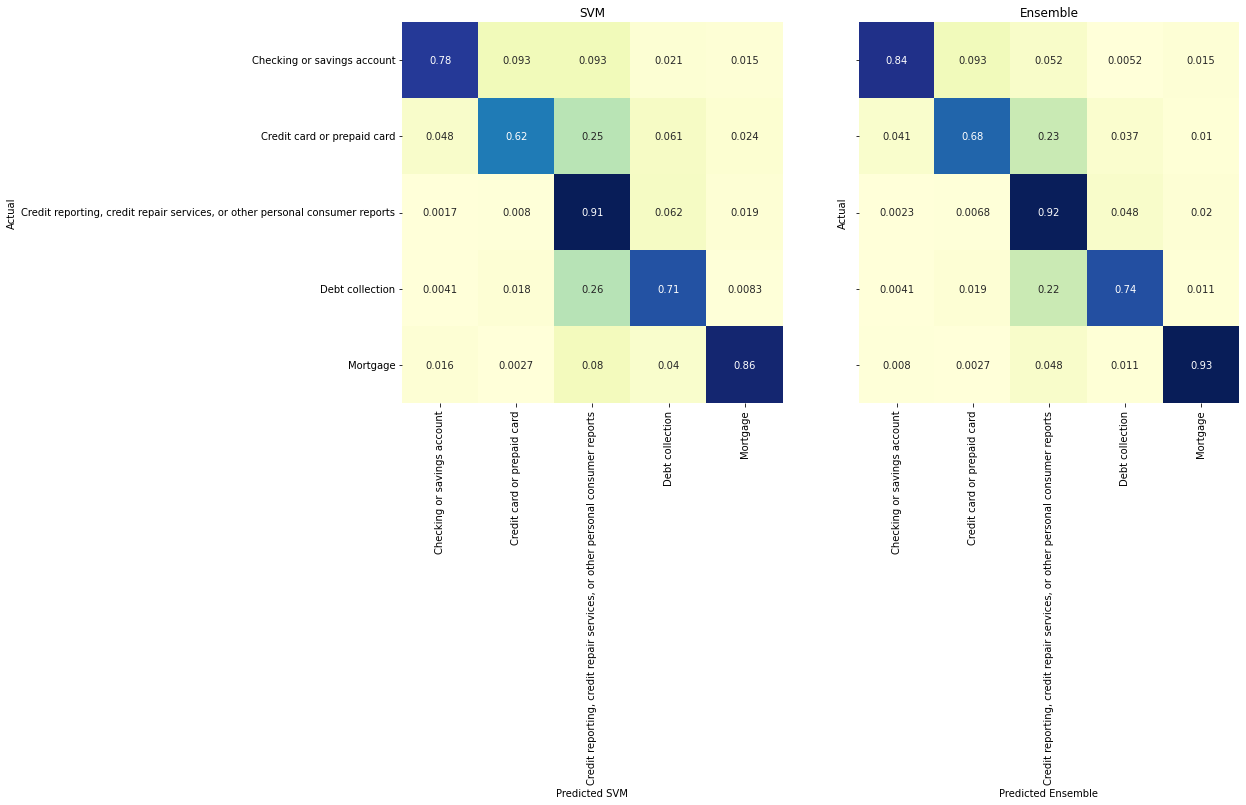

In [34]:
import seaborn as sn

SVM_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted SVM'], rownames=['Actual'], normalize='index')
ensemble_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted Ensemble'], rownames=['Actual'], normalize='index')

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))
# figure, ax1 = plt.subplots(ncols=1, figsize=(7,7))

sn.heatmap(SVM_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
sn.heatmap(ensemble_confusion_df, annot=True, cmap="YlGnBu", ax=ax2, cbar=False)
ax1.title.set_text("SVM")
ax2.title.set_text("Ensemble")
ax2.set_yticklabels([])

plt.show()

<span style="color:blue">In the confusion matrix for the SVM model you can now see that complaints for `Money transfer, virtual currency, or money service` are often misclassified as `Checking or savings account`. Other common misclassifications can be gathered from the table.</span>

<span style="color:blue">Overall, the ensemble model performs better than the SVM model. However, the SVM model had a significantly shorter training time. 

In subsequent steps, consider increasing the size of the training data, tuning the CNN training parameters or adjusting the  weights of the ensemble model to gain better results.</span>

<a id="summary"></a>
## 5. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library and how quickly and easily you can train and run different text classifiers using Watson NLP.</span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation 